In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime
from scipy.stats import multivariate_normal

figsize = (12,6)

## Get data

In [104]:
import requests
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
res = requests.get(url, allow_redirects=True)
with open('owid-covid-latest.csv','wb') as file:
    file.write(res.content)
covid = pd.read_csv('owid-covid-latest.csv')

In [105]:
russia_data = covid[(covid.location=="Russia") & (covid.date >= "2020-03-03")][["date", "total_cases", "new_cases"]]

In [106]:
russia_data.head()

,date,total_cases,new_cases
214893,2020-03-03,3.0,1.0
214894,2020-03-04,3.0,0.0
214895,2020-03-05,3.0,0.0
214896,2020-03-06,4.0,1.0
214897,2020-03-07,4.0,0.0


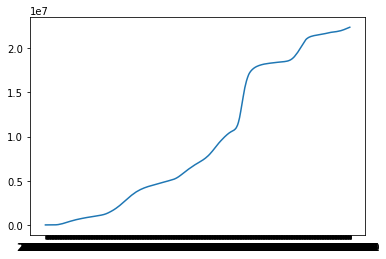

In [107]:
plt.plot(russia_data.date, russia_data.total_cases)

In [108]:
def get_delta_days(day, start_day="2020-03-02"):
  date_format = "%Y-%m-%d"
  a = datetime.strptime(start_day, date_format)
  b = datetime.strptime(day, date_format)
  delta = b - a
  return delta.days

In [109]:
def convert_data(dataset):
  dataset["logTarget"] = np.log(dataset.total_cases)
  dataset["daysFromStart"] = dataset.date.apply(lambda x: get_delta_days(x))
  return dataset

In [110]:
train_data = convert_data(russia_data.iloc[:50])
test_data = convert_data(russia_data.iloc[50:])
train_data.head()

<ipython-input-109-40d7d9d35e82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["logTarget"] = np.log(dataset.total_cases)
<ipython-input-109-40d7d9d35e82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["daysFromStart"] = dataset.date.apply(lambda x: get_delta_days(x))


,date,total_cases,new_cases,logTarget,daysFromStart
214893,2020-03-03,3.0,1.0,1.098612,1
214894,2020-03-04,3.0,0.0,1.098612,2
214895,2020-03-05,3.0,0.0,1.098612,3
214896,2020-03-06,4.0,1.0,1.386294,4
214897,2020-03-07,4.0,0.0,1.386294,5


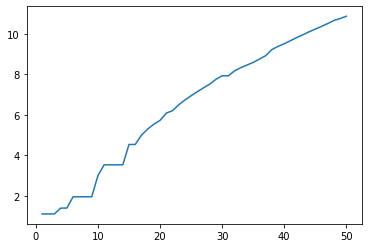

In [111]:
plt.plot(train_data.daysFromStart, train_data.logTarget)

##Linear regression on simple exponent

In [112]:
model = LinearRegression()
model.fit(train_data[["daysFromStart"]], train_data.logTarget)

LinearRegression()

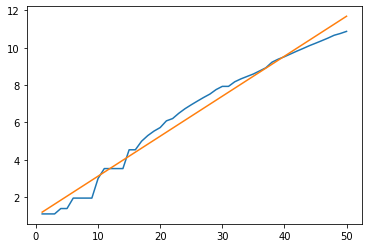

In [113]:
plt.plot(train_data.daysFromStart, train_data.logTarget)
plt.plot(train_data.daysFromStart, model.predict(train_data[["daysFromStart"]]))

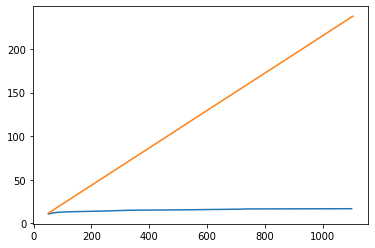

In [114]:
plt.plot(test_data.daysFromStart, test_data.logTarget)
plt.plot(test_data.daysFromStart, model.predict(test_data[["daysFromStart"]]))

In [115]:
# дисперсия шума
noise_var = np.std(model.predict(train_data[["daysFromStart"]]) - train_data.logTarget)
noise_var

0.4498899109116322

In [116]:
mu = np.zeros(2)
sigma = 100 * np.eye(2)

In [117]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x_i] for x_i in x])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y ) )
    return mu_n, sigma_n

In [118]:
cur_mu, cur_sigma = bayesian_update(mu, sigma, train_data.daysFromStart.values, train_data.logTarget.values, noise_var)
cur_mu, cur_sigma

(array([0.97915057, 0.21411118]), array([[ 1.66849635e-02, -4.95592952e-04],
        [-4.95592952e-04,  1.94358045e-05]]))

In [119]:
N = 250

X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [120]:
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

(250, 250)


In [121]:
xs = np.linspace(0, 180, 180)

In [122]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    #plt.ylim((-3, 3))
    #plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

In [123]:
russia_data = convert_data(russia_data)

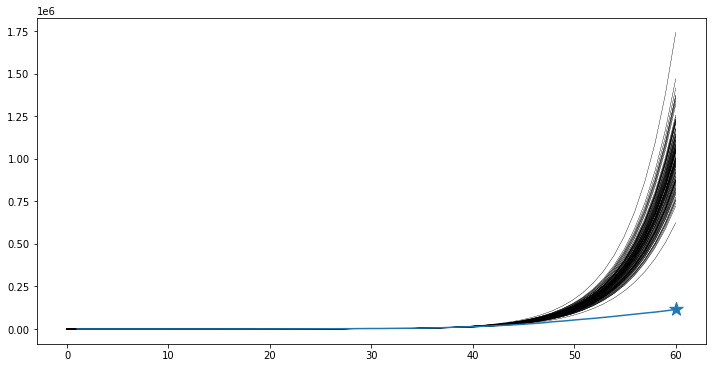

In [124]:
xs = np.linspace(0, 60, 60)
points = [russia_data[russia_data['date'] == '2020-05-01'].daysFromStart.values, russia_data[russia_data['date'] == '2020-05-01'].total_cases.values]
fig = plt.figure(figsize=figsize)
myplot_sample_lines(cur_mu, cur_sigma, 100,
                    points)
plt.plot(russia_data.daysFromStart.values[:60], russia_data.total_cases.values[:60])

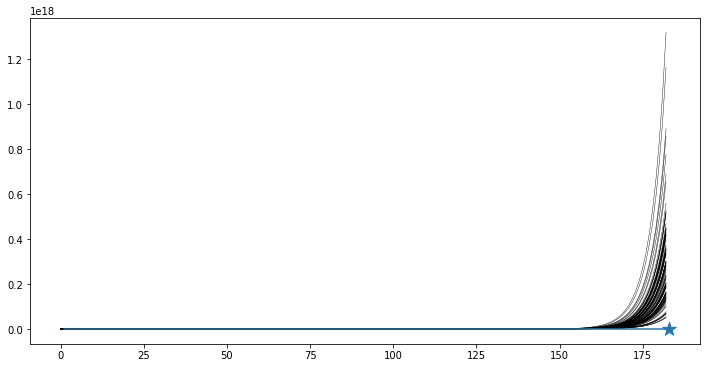

In [125]:
xs = np.linspace(0, 182, 182)
points = [russia_data[russia_data['date'] == '2020-09-01'].daysFromStart.values, russia_data[russia_data['date'] == '2020-09-01'].total_cases.values]
fig = plt.figure(figsize=figsize)
myplot_sample_lines(cur_mu, cur_sigma, 100,
                    points)
plt.plot(russia_data.daysFromStart.values[:182], russia_data.total_cases.values[:182])

## Linear regression with sigmoid

Распишем интеграл:
$$
totalCases(x) =  \int_{-\infty}^{x} e^{at^2 + bt + c} \,dt = \sum_{0}^{x} e^{at^2 + bt + c} = \sum_{0}^{x-1} e^{at^2 + bt + c} + e^{ax^2 + xt + c} = totalCases(x-1) + e^{ax^2 + xt + c}
$$

$$
totalCases(x) - totalCases(x-1) = newCases(x) = e^{ax^2 + xt + c}
$$

$$
log(newCases(x)) = ax^2 + xt + c
$$

In [139]:
def hard_convert_data(dataset):
  dataset["logTarget"] = -1 * np.log(dataset.new_cases + 1)
  dataset["daysFromStart"] = dataset.date.apply(lambda x: get_delta_days(x))
  dataset["daysFromStartSquare"] = dataset.daysFromStart.apply(lambda x: x**2)
  return dataset

In [140]:
new_russia_data = hard_convert_data(russia_data)
new_russia_data.head()

,date,total_cases,new_cases,logTarget,daysFromStart,daysFromStartSquare
214893,2020-03-03,3.0,1.0,-0.693147,1,1
214894,2020-03-04,3.0,0.0,-0.000000,2,4
214895,2020-03-05,3.0,0.0,-0.000000,3,9
214896,2020-03-06,4.0,1.0,-0.693147,4,16
214897,2020-03-07,4.0,0.0,-0.000000,5,25


In [141]:
new_train_data = convert_data(new_russia_data.iloc[:50])
new_test_data = convert_data(new_russia_data.iloc[50:])
new_train_data.head()

<ipython-input-109-40d7d9d35e82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["logTarget"] = np.log(dataset.total_cases)
<ipython-input-109-40d7d9d35e82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["daysFromStart"] = dataset.date.apply(lambda x: get_delta_days(x))


,date,total_cases,new_cases,logTarget,daysFromStart,daysFromStartSquare
214893,2020-03-03,3.0,1.0,1.098612,1,1
214894,2020-03-04,3.0,0.0,1.098612,2,4
214895,2020-03-05,3.0,0.0,1.098612,3,9
214896,2020-03-06,4.0,1.0,1.386294,4,16
214897,2020-03-07,4.0,0.0,1.386294,5,25


In [142]:
model_sgm = LinearRegression()
model_sgm.fit(new_train_data[["daysFromStart", "daysFromStartSquare"]], new_train_data.logTarget)

LinearRegression()

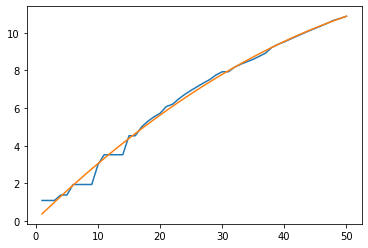

In [143]:
plt.plot(new_train_data.daysFromStart, new_train_data.logTarget)
plt.plot(new_train_data.daysFromStart, model_sgm.predict(new_train_data[["daysFromStart", "daysFromStartSquare"]]))

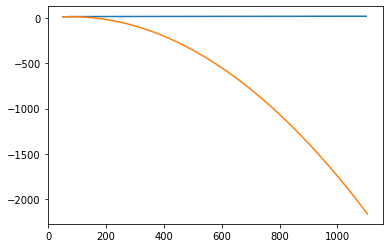

In [144]:
plt.plot(new_test_data.daysFromStart, new_test_data.logTarget)
plt.plot(new_test_data.daysFromStart, model_sgm.predict(new_test_data[["daysFromStart", "daysFromStartSquare"]]))